Could not import SolaraViz. If you need it, install with 'pip install --pre mesa[viz]'


/usr/local/anaconda3/envs/pil_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Test 1 & 2 & 3: Normal Gravity with Competing Vortices


/var/folders/_3/bg4ltz5x7nx864wk66d7w3sr0000gn/T/ipykernel_19580/3406604308.py:103: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)


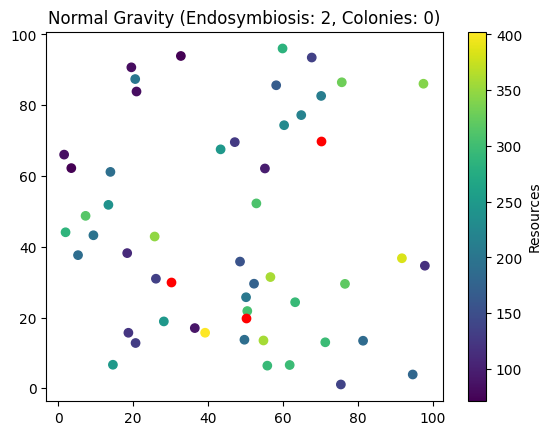

Endosymbiosis Events: 2, Organelle Agents: 2, Colonies: 0, Avg Resources: 215.70

Test 1 & 2 & 3: Microgravity


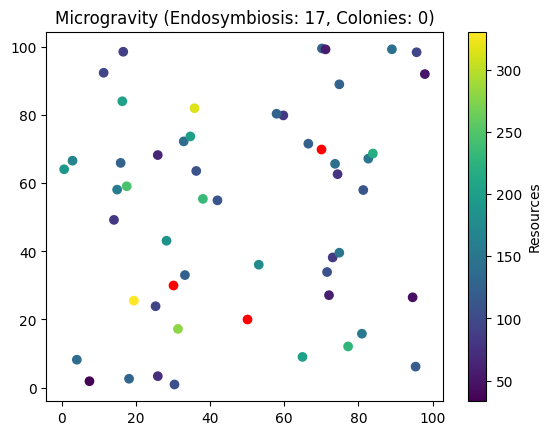

Endosymbiosis Events: 17, Organelle Agents: 17, Colonies: 0, Avg Resources: 139.56


In [1]:
import numpy as np
from scipy import constants
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import random

# Gravity settings
G_NORMAL = 0.1  # Scaled for cellular scale
G_MICRO = 0

# Multiple gravitational masses (position, strength)
MASSES = [
    (np.array([30, 30]), 1.0),
    (np.array([70, 70]), 0.8),
    (np.array([50, 20]), 0.6)
]

class PreyAgent(Agent):
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.pos = None
        self.resources = 5

    def step(self):
        if self.model.G != G_MICRO:
            # Vortex movement around nearest mass
            nearest_mass_pos, mass_strength = min(
                MASSES, key=lambda m: np.linalg.norm(self.pos - m[0])
            )
            r = np.linalg.norm(self.pos - nearest_mass_pos)
            if r > 0:
                force = self.model.G * mass_strength * 0.05 / (r**2)
                direction = (nearest_mass_pos - self.pos) / r
                # Add rotational component (perpendicular to radial direction)
                vortex = np.array([-direction[1], direction[0]]) * 0.1
                self.pos += (direction * force + vortex) * 0.1
        self.pos = np.clip(self.pos, 0, 100)

class ChoanoAgent(Agent):
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.pos = None
        self.resources = 0
        self.consumption_rate = np.random.uniform(0.1, 0.5)
        self.has_organelle = False
        self.colony = None

    def step(self):
        if self.model.G != G_MICRO:
            # Move toward nearest mass with vortex
            nearest_mass_pos, mass_strength = min(
                MASSES, key=lambda m: np.linalg.norm(self.pos - m[0])
            )
            r = np.linalg.norm(self.pos - nearest_mass_pos)
            if r > 0:
                force = self.model.G * mass_strength / (r**2)
                direction = (nearest_mass_pos - self.pos) / r
                vortex = np.array([-direction[1], direction[0]]) * 0.2
                self.pos += (direction * force + vortex) * 0.1
        else:
            # Microgravity disruption
            self.pos += np.random.uniform(-1.0, 1.0, 2)

        # Resource consumption based on nearest mass
        nearest_mass_pos, _ = min(MASSES, key=lambda m: np.linalg.norm(self.pos - m[0]))
        r = np.linalg.norm(self.pos - nearest_mass_pos)
        resource_density = max(0, 10 - r / 10)
        gravity_factor = 0.5 if self.model.G == G_MICRO else 1.0
        self.resources += self.consumption_rate * resource_density * (2 if self.has_organelle else 1) * gravity_factor

        # Endosymbiosis
        neighbors = self.model.space.get_neighbors(self.pos, 2, include_center=False)
        for neighbor in neighbors:
            if isinstance(neighbor, PreyAgent) and not self.has_organelle:
                self.has_organelle = True
                self.resources += neighbor.resources
                self.model.space.remove_agent(neighbor)
                self.model.schedule.remove(neighbor)
                self.model.endosymbiosis_events += 1
                break

        # Colony formation
        if not self.colony:
            colony_neighbors = [a for a in neighbors if isinstance(a, ChoanoAgent) and a.unique_id != self.unique_id]
            bond_chance = 0.3 if self.model.G != G_MICRO else 0.05
            if colony_neighbors and random.random() < bond_chance:
                self.colony = colony_neighbors[0].colony or self.unique_id
                for n in colony_neighbors:
                    n.colony = self.colony

        self.pos = np.clip(self.pos, 0, 100)

class GravityModel(Model):
    def __init__(self, N_choano, N_prey, G):
        super().__init__()
        self.random = random.Random()
        self.G = G
        self.space = ContinuousSpace(100, 100, torus=False)
        self.schedule = RandomActivation(self)
        self.endosymbiosis_events = 0

        for i in range(N_choano):
            agent = ChoanoAgent(i, self)
            self.schedule.add(agent)
            initial_pos = np.array([np.random.uniform(0, 100), np.random.uniform(0, 100)])
            self.space.place_agent(agent, initial_pos)

        for i in range(N_prey):
            prey = PreyAgent(N_choano + i, self)
            self.schedule.add(prey)
            initial_pos = np.array([np.random.uniform(0, 100), np.random.uniform(0, 100)])
            self.space.place_agent(prey, initial_pos)

    def step(self):
        self.schedule.step()

def run_test(gravity, label):
    model = GravityModel(50, 50, gravity)
    for _ in range(100):
        model.step()

    positions = [agent.pos for agent in model.schedule.agents if isinstance(agent, ChoanoAgent)]
    x, y = zip(*positions)
    resources = [agent.resources for agent in model.schedule.agents if isinstance(agent, ChoanoAgent)]
    organelle_count = sum(1 for agent in model.schedule.agents if isinstance(agent, ChoanoAgent) and agent.has_organelle)
    colonies = {}
    for agent in model.schedule.agents:
        if isinstance(agent, ChoanoAgent) and agent.colony:
            colonies[agent.colony] = colonies.get(agent.colony, []) + [agent]
    colony_count = len([c for c in colonies.values() if len(c) >= 3])

    plt.scatter(x, y, c=resources, cmap="viridis")
    plt.colorbar(label="Resources")
    for pos, _ in MASSES:
        plt.plot(pos[0], pos[1], 'ro')  # Mark gravitational masses
    plt.title(f"{label} (Endosymbiosis: {model.endosymbiosis_events}, Colonies: {colony_count})")
    plt.show()

    return model.endosymbiosis_events, organelle_count, colony_count, np.mean(resources)

# Run tests
print("Test 1 & 2 & 3: Normal Gravity with Competing Vortices")
normal_results = run_test(G_NORMAL, "Normal Gravity")
print(f"Endosymbiosis Events: {normal_results[0]}, Organelle Agents: {normal_results[1]}, Colonies: {normal_results[2]}, Avg Resources: {normal_results[3]:.2f}")

print("\nTest 1 & 2 & 3: Microgravity")
micro_results = run_test(G_MICRO, "Microgravity")
print(f"Endosymbiosis Events: {micro_results[0]}, Organelle Agents: {micro_results[1]}, Colonies: {micro_results[2]}, Avg Resources: {micro_results[3]:.2f}")